In [12]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase

from analysis.quarterly_analysis import QuarterlyAnalysis as anas

## risk and return class imports
from returns.products import Products as returns_products_class
from strategy.strategy import Strategy as strategy_list
from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [13]:
market = Market()

In [14]:
strats = [
        strategy_list.STOCK_QUARTERLY_FINANCIAL
         ]
model_start_date  = datetime(2020,1,1)
model_end_date  = datetime(2022,1,1)
current_start_date  = datetime(2021,1,1)
fund = Fund(strats,model_start_date,model_end_date,current_start_date)
fund.initialize_strats()

In [15]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [16]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [17]:
t = fund.pull_trades()
t = pd.concat(t)

In [34]:
nonindex_columns = [
"year"
,"quarter"
,"ticker"
,"delta_sign"
,"delta"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [35]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [36]:
indexer

['value', 'ceiling', 'strat']

In [37]:
analysis = []
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","quarter"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(ledger["positions"].mean())
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        break
        continue
a = pd.DataFrame(analysis)

In [38]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,ceiling,pv,beta,rrr,sharpe
0,quarterly_prices_financial,False,False,1.249506,20.29805,3.899345,0.009711


In [39]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","quarter","ticker","projected_quarterly_return","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

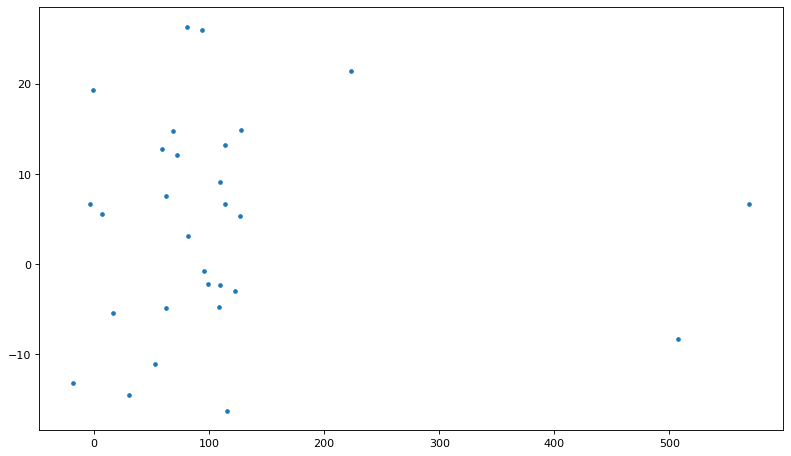

In [40]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger["projected_quarterly_return"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [41]:
ledger.sort_values("actual_returns",ascending=False)

,year,quarter,ticker,projected_quarterly_return,actual_returns,position,GICS Sector,Security
20,2022,4,AFL,0.810753,1.263193,5,Financials,Aflac
18,2022,4,APA,0.937191,1.259012,4,Energy,APA Corporation
0,2021,1,APA,2.230782,1.213737,0,Energy,APA Corporation
5,2021,1,AFL,-0.005423,1.193433,1,Financials,Aflac
1,2021,2,APA,1.278588,1.149154,0,Energy,APA Corporation
24,2022,4,ALLE,0.683497,1.147175,7,Industrials,Allegion
8,2022,4,AMAT,1.135399,1.131770,1,Information Technology,Applied Materials
28,2022,4,MO,0.586435,1.127689,9,Consumer Staples,Altria
22,2022,4,APTV,0.717405,1.121508,6,Consumer Discretionary,Aptiv
12,2022,4,AMCR,1.094173,1.090814,2,Materials,Amcor


In [42]:
portfolio = ledger.pivot_table(index=["year","quarter"],columns="position",values="actual_returns").fillna(1).reset_index()

In [43]:
portfolio

position,year,quarter,0,1,2,3,4,5,6,7,8,9
0,2021,1,1.213737,1.193433,1.066146,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2021,2,1.149154,0.992701,0.888935,1.055950,0.867895,1.000000,1.000000,1.000000,1.000000,1.000000
2,2021,3,0.945651,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,2022,3,0.916984,1.053224,0.970817,0.837349,1.067173,0.977253,0.952126,1.031398,0.950935,0.855221
4,2022,4,1.067114,1.131770,1.090814,0.978019,1.259012,1.263193,1.121508,1.147175,1.075921,1.127689


In [44]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [45]:
cumulative

,0,1,2,3,4,5,6,7,8,9,date,pv,adjclose,bench
0,1.213737,1.193433,1.066146,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021-03-01,1.162518,389.58,1.000000
1,1.394770,1.184722,0.947735,1.055950,0.867895,1.000000,1.000000,1.000000,1.000000,1.000000,2021-06-01,1.235425,419.67,1.077237
2,1.318965,1.184722,0.947735,1.055950,0.867895,1.000000,1.000000,1.000000,1.000000,1.000000,2021-09-01,1.197522,451.80,1.159710
3,1.209470,1.247778,0.920077,0.884199,0.926194,0.977253,0.952126,1.031398,0.950935,0.855221,2022-09-01,1.145325,396.42,1.017557
4,1.290643,1.412198,1.003634,0.864764,1.166089,1.234459,1.067817,1.183195,1.023131,0.964423,2022-12-01,1.249506,407.38,1.045690


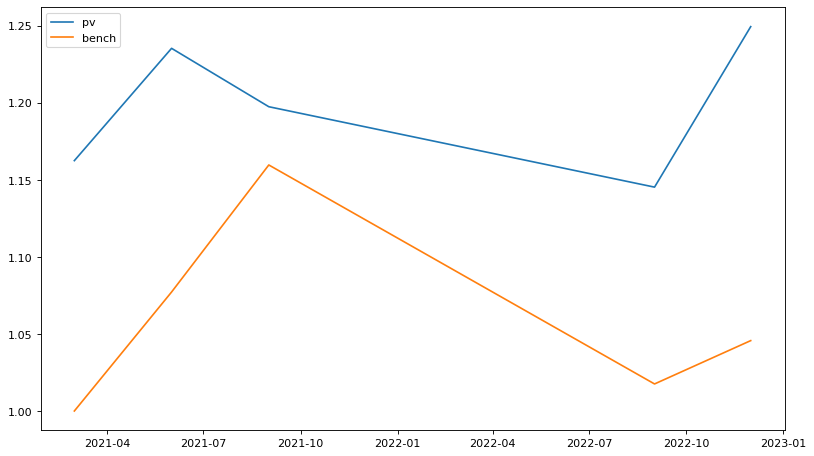

In [46]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

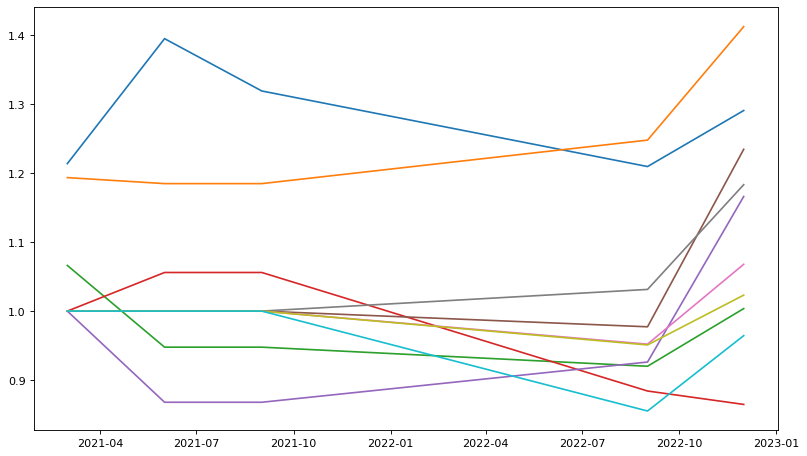

In [47]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [48]:
ledger.groupby(["GICS Sector"]).mean().sort_values("projected_quarterly_return",ascending=False)

,year,quarter,projected_quarterly_return,actual_returns,position
GICS Sector,,,,,
Industrials,2021.714286,3.142857,1.863875,0.987851,4.142857
Energy,2021.500000,2.500000,1.417241,1.148180,1.500000
Utilities,2022.000000,3.000000,1.134885,1.067173,4.000000
Health Care,2022.000000,3.500000,1.068594,0.907684,3.000000
Materials,2021.500000,3.000000,1.026073,1.041758,1.500000
Consumer Staples,2022.000000,3.500000,0.840780,1.052471,7.000000
Information Technology,2021.600000,2.800000,0.722455,1.029783,2.000000
Consumer Discretionary,2022.000000,3.333333,0.611890,1.002709,7.333333
Financials,2021.333333,2.333333,0.289912,1.170859,3.000000


In [49]:
ledger.groupby(["ticker","Security"]).prod().sort_values("actual_returns",ascending=False).tail(30)

,,year,quarter,projected_quarterly_return,actual_returns,position
ticker,Security,,,,,
APA,APA Corporation,16699171677444,24,3.267606,1.704786,0
AFL,Aflac,8258739702,8,-0.000283,1.591884,15
ALLE,Allegion,2022,4,0.683497,1.147175,7
MO,Altria,4088484,12,0.642219,1.102037,45
AMCR,Amcor,4086462,8,1.048187,1.082853,2
AMAT,Applied Materials,4088484,12,1.236486,1.077588,6
AES,AES Corporation,2022,3,1.134885,1.067173,4
APH,Amphenol,2022,3,1.265261,1.053224,1
AMZN,Amazon,2022,3,0.814159,1.031398,7


In [50]:
industry_analysis = ledger.pivot_table(index=["year","quarter"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,quarter,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Utilities
0,2021,1,1.000000,1.000000,1.213737,1.193433,1.000000,1.000000,1.066146,1.000000,1.000000
1,4084441,2,1.000000,1.000000,1.394770,1.260206,1.000000,0.878415,1.066146,0.992701,1.000000
2,8254655261,6,1.000000,1.000000,1.394770,1.260206,1.000000,0.878415,1.008202,0.992701,1.000000
3,16690912937742,18,0.943310,0.977253,1.354067,1.260206,0.837349,0.820404,1.010899,0.992701,1.067173
4,33749025960114324,72,1.057929,1.102037,1.704786,1.591884,0.818944,0.899767,1.144105,1.082853,1.067173
